In [1]:
using Pkg; Pkg.activate(".")
using HypergraphModularity

# using Optim 
using Plots
using TimerOutputs
using StatsBase

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [2]:
α0 = vcat([0.0, 0.0, 10.0], [0.0, 5.0, 0.0])
kmax = 3
n = 200
ϑ = repeat([1.0], n);

# all-or-nothing cut with dyadic edges always between group
function Ω(z; α, mode = "group")
    
    p = (mode == "group") ? partitionize(z) : z
    
    k = sum(p)
    
    if length(p) == 1
        return α[k]/n^(k-1)
    elseif length(p) == 2
        return α[kmax+k]/n^(k-1)
    else
        return α[kmax+k]/n^(k)
    end
end

Ω (generic function with 1 method)

In [20]:
function percent_identified(Z, Ẑ)
    d = Dict()
    for i = 1:length(Z)
        d[(Z[i], Ẑ[i])] = get(d, (Z[i], Ẑ[i]), 0) + 1
    end
    if length(unique(Ẑ)) > 1
        return 2*maximum(values(d)) / length(Z)
    else
        return 0
    end
end

percent_identified (generic function with 1 method)

In [123]:
kmax = 3

weighted = false

A = 0.0:1.0:30

n_runs = 5

C = zeros(0)
P = zeros(0)

for i in 1:(length(A)), j in 1:n_runs
    a = A[i]
    Z = vcat(repeat([1], n÷2), repeat([2], n÷2))
    α0 = vcat([0.0, 0.0, a], [0.0, 5.0, 0.0])
    H = sampleSBM(Z, ϑ, Ω;α=α0, kmax=kmax, kmin = 1)
    H.E[1] = Dict()
        
#     cᵢ = sum(values(H.E[3]))*3/n
#     cₒ = sum(values(H.E[2]))*1/n
    
    cᵢ = 3*a/4          
    cₒ = α0[5]/2
    
    append!(C, (cᵢ - cₒ)/sqrt(2*(cᵢ + cₒ)))
        
    Z_ = copy(Z)
    
    n_reps = 10
    
    best_L = -Inf
    best_identified = 0
    
    for i in 1:n_reps
        γ̂ = computeDyadicResolutionParameter(H, Z_)
        Z_ = CliqueExpansionModularity(H, γ̂, weighted, true)
        ω_in, ω_out = computeDyadicResolutionParameter(H, Z_; mode="ω", weighted=weighted)
        L_D = dyadicLogLikelihood(H, Z_, ω_in, ω_out, weighted=weighted)
        
        if L_D > best_L
            best_L = L_D
            best_identified = percent_identified(Z, Z_)
        end
    end
    append!(P, best_identified)
end

In [148]:
kmax = 3

weighted = true

A = 0.0:1.0:30

n_runs = 5

C__ = zeros(0)
P__ = zeros(0)

for i in 1:(length(A)), j in 1:n_runs
    a = A[i]
    Z = vcat(repeat([1], n÷2), repeat([2], n÷2))
    α0 = vcat([0.0, 0.0, a], [0.0, 5.0, 0.0])
    H = sampleSBM(Z, ϑ, Ω;α=α0, kmax=kmax, kmin = 1)
    H.E[1] = Dict()
            
    cᵢ = 3*a/(2*4)          
    cₒ = α0[5]/2
    
    append!(C__, (cᵢ - cₒ)/sqrt(2*(cᵢ + cₒ)))
        
    Z_ = copy(Z)
    
    n_reps = 10
    
    best_L = -Inf
    best_identified = 0
    
    for i in 1:n_reps
        γ̂ = computeDyadicResolutionParameter(H, Z_)
        Z_ = CliqueExpansionModularity(H, γ̂, weighted, true)
        ω_in, ω_out = computeDyadicResolutionParameter(H, Z_; mode="ω", weighted=weighted)
        L_D = dyadicLogLikelihood(H, Z_, ω_in, ω_out, weighted=weighted)
        
        if L_D > best_L
            best_L = L_D
            best_identified = percent_identified(Z, Z_)
        end
    end
    append!(P__, best_identified)
end

In [127]:
kmax = 3

weighted = false

A = 0.0:1.0:30

n_runs = 5

C_ = zeros(0)
P_ = zeros(0)

for i in 1:length(A)
    a = A[i]
    Z = vcat(repeat([1], n÷2), repeat([2], n÷2))
    α0 = vcat([0.0, 0.0, a], [0.0, 5.0, 0.0])
    H = sampleSBM(Z, ϑ, Ω;α=α0, kmax=kmax, kmin = 1)
    H.E[1] = Dict()
        
    cᵢ = 3*a/4          
    cₒ = α0[5]/2
    
    append!(C_, (cᵢ - cₒ)/sqrt(2*(cᵢ + cₒ)))
    
    Z_ = copy(Z)
    α̂ = α0
    
    best_L = -Inf
    best_identified = 0
    
    n_reps = 10
    
    for i in 1:n_reps
        α̂ = coordinateAscent(H, Z_, Ω, α̂; n_iters = 10, amin = 10^(-10), amax = 10)
        Z_ = SuperNodeLouvain(H,kmax,Ω;α=α̂, verbose=false, scan_order ="random")
        L_H = modularity(H, Z_, Ω; α = α̂)
        
        if L_H > best_L
            best_L = L_H
            best_identified = percent_identified(Z, Z_)
        end
    end
    append!(P_, best_identified)
end

In [149]:
using RCall
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 350, :height => 250))
R"""
library(tidyverse)
"""

RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


┌ Warning: RCall.jl: `summarise()` regrouping output by 'C' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


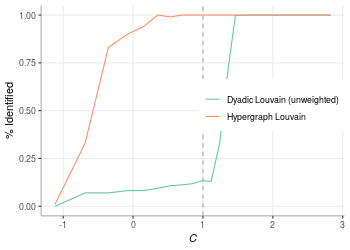

RObject{VecSxp}


In [157]:
R"""

df_D <- tibble(C = $C_, P = $P_, algorithm = "Hypergraph Louvain")
# df_D_W <- tibble(C = $C__, P = $P__, algorithm = "Dyadic Louvain (weighted)")
df_H <- tibble(C = $C,  P = $P, algorithm = "Dyadic Louvain (unweighted)")

df <- rbind(df_D, df_H) %>% 
#    rbind(df_D_W) %>% 
    group_by(C, algorithm) %>% 
    summarise(P = mean(P))

df %>% 
    ggplot() + 
    aes(x = C, y = P, fill = algorithm) +
    geom_vline(aes(xintercept = 1), color = "darkgrey", size = .5, linetype = "dashed") + 
    geom_line(aes(color = algorithm)) + 
    theme_bw() + 
    theme(panel.border = element_blank(),
          axis.line = element_line(color = 'darkgrey'),
          panel.grid.minor = element_blank(),
          legend.position = c(1.0, .65),
          legend.justification = c("right", "top"),
          legend.box.just = "right",
          legend.margin = margin(6, 6, 6, 6),
          legend.title = element_blank()) + 
    xlab(expression(italic(C))) + 
    ylab("% Identified") + 
    scale_color_brewer(palette = "Set2") + 
    scale_fill_brewer(palette = "Set2")
"""

In [151]:
R"""
ggsave("fig/resolution_limit.png", width = 5, height = 3.7)
"""

RObject{NilSxp}
NULL


# TODO

Make a nicer plot via ggplot, check in on the location of the phase transition. 